In [1]:
# Allows us to import files from the base folder
import sys
import os
# Get the parent directory of the notebook's folder
base_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(base_dir)

# Imports
import jax
import jax.numpy as jnp
from jax import grad, vmap, jit, value_and_grad
import optax

import matplotlib.pyplot as plt

from packages.quantum_error_correction import *
from packages.neural_network import *

from icecream import ic  # For debugging

key = jax.random.key(42)

num_dq = 25 | num_sq = 24


(<Figure size 1920x1440 with 1 Axes>,
 <Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>)

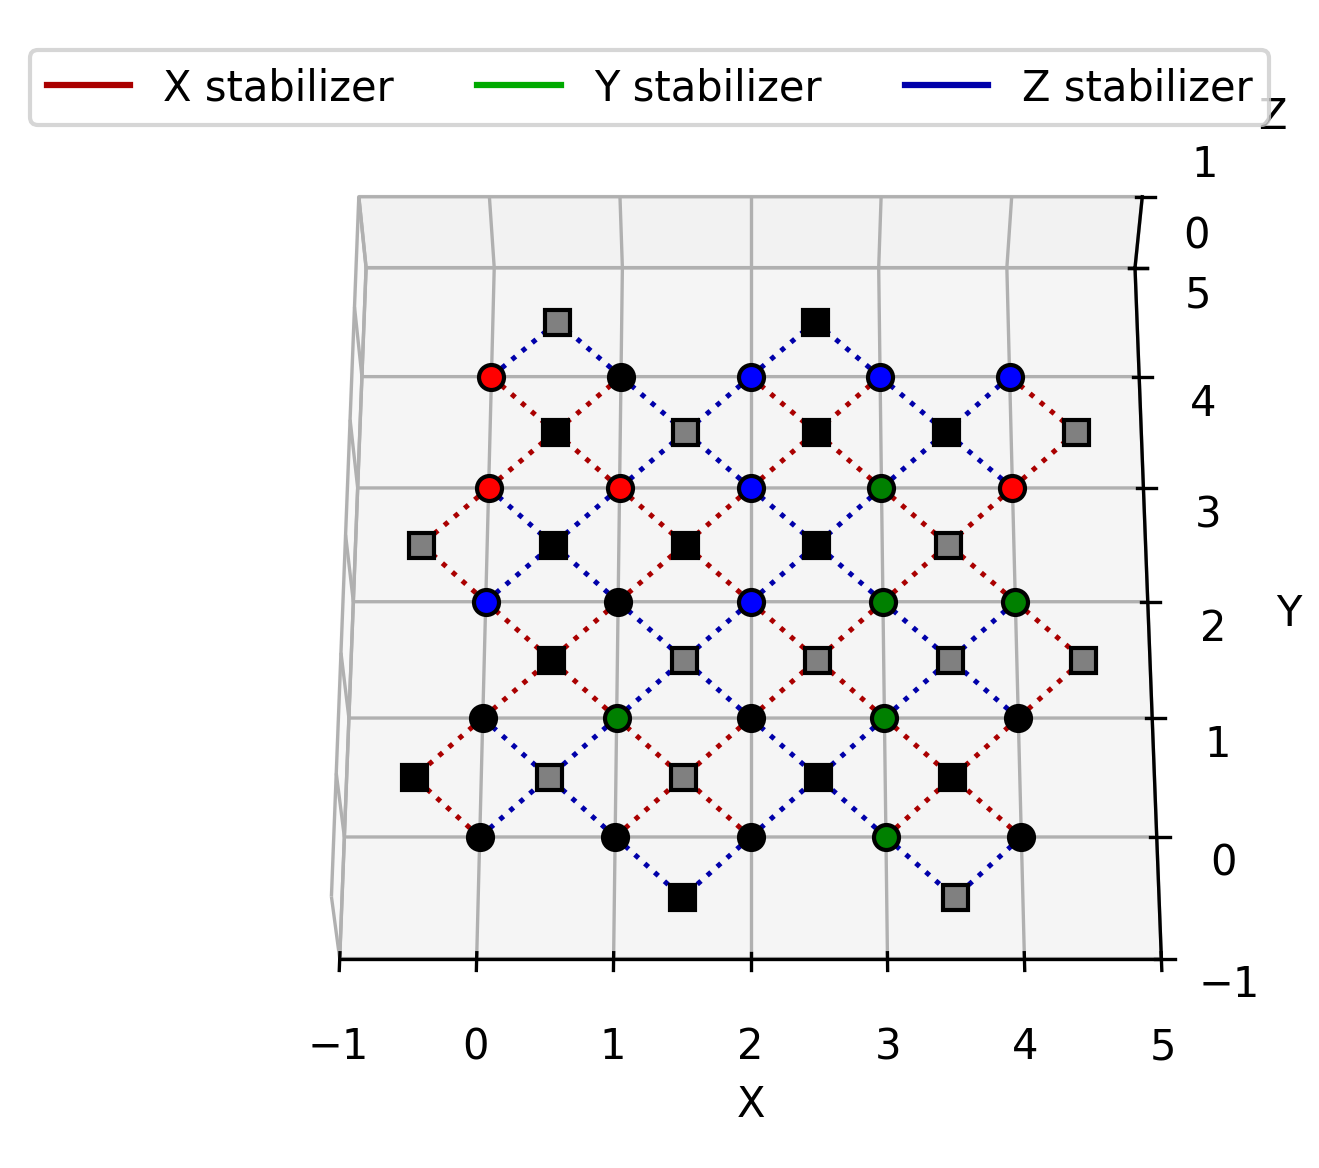

In [2]:
d = 5
px, py, pz = .25, .25, .25

qec = QEC(surface_code_data(d))
# qec = QEC(repetion_code_data(d, 'z'))

Mx, My, Mz = qec.transformation_matrix()
num_sq, num_dq = Mx.shape
print(f'{num_dq = } | {num_sq = }')

subkey, key = jax.random.split(key)
errors=jax_create_error_batch(px, py, pz, num_dq, batch_size=1 ,key=subkey)
qec.show(marker_size=60/d, errors=errors[0])

# Setup neural network

In [3]:
def interpretate_NN_output(NN_output: jnp.ndarray) -> jnp.ndarray:
    """
    Uses the floating value in the range of 0 and 1 as a probability for the predicted value
    """
    logits = NN_output.reshape((4, NN_output.shape[0]//4))
    probabilities = jnp.exp(logits) / jnp.sum(jnp.exp(logits), axis=0)
    return probabilities

batch_interpretate_NN_output = jax.vmap(
    interpretate_NN_output, 
    in_axes=0, 
    out_axes=0
)

In [4]:
# Create a neural network
NN_batch = vmap( NN, in_axes = [0,None], out_axes = 0)

def score(NN_correction: jnp.ndarray, errors: jnp.ndarray) -> jnp.ndarray:
    correct_answer = errors == jnp.arange(4)[:, None]
    return (NN_correction - correct_answer)**2

score_batch = vmap(score)

def mse_loss_batch(syndromes: jnp.ndarray, errors: jnp.ndarray, params):
    # Get the output of the NN
    NN_output = NN_batch(syndromes, params)
    # The probability distribution of the correction proposed by the NN
    NN_correction = batch_interpretate_NN_output(NN_output)
    # Calculate the score as the sum of the probabilities of the incorrect answers
    # Normalize the score
    return score_batch(NN_correction, errors).mean()

# take gradient with respect to params (argument number '2' out of 0,1,2)
# also return value of loss:
mse_loss_batch_val_grad = value_and_grad(mse_loss_batch, argnums=2)

mse_loss_batch_val_grad = jax.jit( mse_loss_batch_val_grad  )

# number of neurons in each hidden layer:
num_neurons_layers = [num_sq, 8*num_dq, 8*num_dq, 4*num_dq]

subkey, key = jax.random.split(key)
params = NN_init_params( subkey, num_neurons_layers )

### Test the untrained neural network

In [5]:
batch_size = 1

# Create some sample data
subkey, key = jax.random.split(key)
errors = jax_create_error_batch(px, py, pz, size=num_dq, batch_size=batch_size, key=subkey)
syndromes = jax_get_syndromes_batch(Mx, My, Mz, errors)

print(errors[0])

# Evaluate the NN on the sample data
NN_output = NN_batch(syndromes, params)
NN_correction = batch_interpretate_NN_output(NN_output)
print("\nPauli correction probability for:\nQubit    I        X        Y        Z\n"+'\n'.join([f'  {i}  '+', '.join([f'{v: 7.1%}' for v in p]) for i, p in enumerate(NN_correction[0].T)]))

print(f'\nLoss = {mse_loss_batch(syndromes, errors, params)}')

[0 2 1 0 0 1 0 0 2 2 1 3 0 1 1 1 2 1 1 3 2 1 1 1 3]

Pauli correction probability for:
Qubit    I        X        Y        Z
  0    35.6%,   19.7%,   26.4%,   18.2%
  1    23.9%,   22.7%,   24.5%,   29.0%
  2    22.1%,   30.0%,   21.5%,   26.5%
  3    24.2%,   33.0%,   26.6%,   16.1%
  4    24.8%,   18.0%,   35.1%,   22.0%
  5    28.2%,   19.1%,   25.5%,   27.2%
  6    30.7%,   28.8%,   21.2%,   19.4%
  7    24.7%,   18.0%,   26.5%,   30.8%
  8    26.3%,   23.5%,   19.9%,   30.3%
  9    41.0%,   15.6%,   22.8%,   20.6%
  10    20.4%,   39.5%,   19.7%,   20.4%
  11    27.5%,   29.2%,   20.7%,   22.6%
  12    22.3%,   36.5%,   21.4%,   19.8%
  13    28.1%,   27.8%,   20.6%,   23.5%
  14    31.8%,   26.6%,   17.7%,   23.9%
  15    26.4%,   25.8%,   20.9%,   26.9%
  16    19.2%,   27.1%,   22.2%,   31.5%
  17    28.6%,   20.8%,   27.9%,   22.6%
  18    22.7%,   29.4%,   23.1%,   24.9%
  19    31.2%,   32.2%,   20.1%,   16.5%
  20    30.7%,   19.8%,   21.3%,   28.2%
  21    25.0%,   29.5%, 

In [6]:
errors_ =         jnp.array([[2,1,0,0,0]])
NN_correction_ = jnp.array([[[0,0,1,1,1],
                   [0,1,0,0,0],
                   [0,0,0,0,0],
                   [0,0,0,0,0]]])
NN_correction_

print(errors_[0])
print("\nPauli correction probability for:\nQubit    I        X        Y        Z\n"+'\n'.join([f'  {i}  '+', '.join([f'{v: 7.1%}' for v in p]) for i, p in enumerate(NN_correction_[0].T)]))

print(f'\nLoss = {score_batch(NN_correction_, errors_).mean()}')

[2 1 0 0 0]

Pauli correction probability for:
Qubit    I        X        Y        Z
  0     0.0%,    0.0%,    0.0%,    0.0%
  1     0.0%,  100.0%,    0.0%,    0.0%
  2   100.0%,    0.0%,    0.0%,    0.0%
  3   100.0%,    0.0%,    0.0%,    0.0%
  4   100.0%,    0.0%,    0.0%,    0.0%

Loss = 0.05000000074505806


# Train neural network

In [7]:
learning_rate = 1e-2

# get the optimizer:
optimizer = optax.adam( learning_rate )
# initialize the 'state' of the optimizer, by
# telling it about the initial values:
opt_state = optimizer.init( params )

In [8]:
# training parameters
num_training_batches = 1000
batchsize = 512
losses=[]

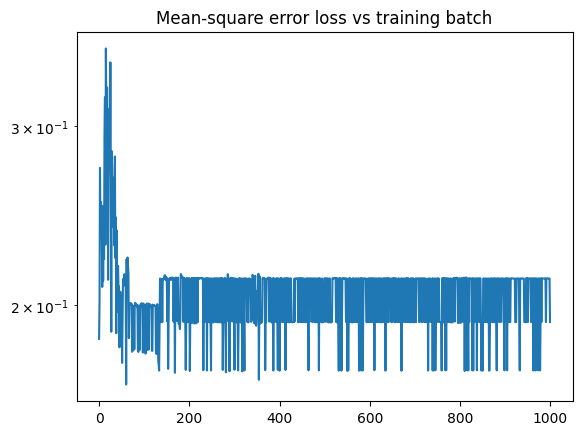

In [9]:
# run this cell multiple times to continue training!

for idx_batch in range(num_training_batches): 
    print(f'{idx_batch+1} of {num_training_batches}', end='\r')

    # get training batch
    subkey, key = jax.random.split(key)
    errors = jax_create_error_batch(px, py, pz, size=num_dq, batch_size=batch_size, key=subkey)
    syndromes = jax_get_syndromes_batch(Mx, My, Mz, errors)
    
    # get loss and its gradient with respect to network parameters:
    # mse_loss_batch(Mx: jnp.ndarray, My: jnp.ndarray, Mz: jnp.ndarray, actual_syndrome: jnp.ndarray, samples: int, params, key):
    loss, grads = mse_loss_batch_val_grad(syndromes, errors, params)

    # update the network parameters:
    updates, opt_state = optimizer.update( grads, opt_state )
    params = optax.apply_updates( params, updates )

    # add the loss to the list:
    losses.append(loss)

plt.plot( losses )
plt.yscale( "log" )
plt.title("Mean-square error loss vs training batch")
plt.show()


Pauli correction probability for:
Qubit    I        X        Y        Z
  0    25.0%,   25.0%,   25.0%,   25.0%
  1    25.0%,   25.0%,   25.0%,   25.1%
  2    25.0%,   25.0%,   24.9%,   25.1%
  3     0.0%,    0.0%,  100.0%,    0.0%
  4    25.1%,   25.0%,   25.0%,   25.0%
  5    25.0%,   25.0%,   25.0%,   25.0%
  6    25.0%,   25.0%,   25.1%,   25.0%
  7    25.0%,   25.0%,   25.0%,   25.0%
  8    25.0%,   25.0%,   25.0%,   25.0%
  9    25.0%,   25.0%,   25.0%,   25.0%
  10    25.0%,   25.1%,   24.9%,   25.0%
  11    25.0%,   25.0%,   25.0%,   25.0%
  12    25.0%,   25.0%,   25.0%,   25.0%
  13    25.0%,   25.0%,   25.0%,   25.1%
  14    25.0%,   25.0%,   25.0%,   25.0%
  15    25.0%,   25.0%,   25.1%,   25.0%
  16    25.0%,   25.0%,   25.0%,   25.0%
  17    25.0%,   25.0%,   25.0%,   25.0%
  18    25.0%,   25.0%,   25.0%,   25.0%
  19    25.0%,   25.0%,   25.0%,   25.0%
  20    25.0%,   25.0%,   25.0%,   25.0%
  21    25.0%,   25.0%,   25.0%,   25.0%
  22     0.0%,  100.0%,    0.0%,   

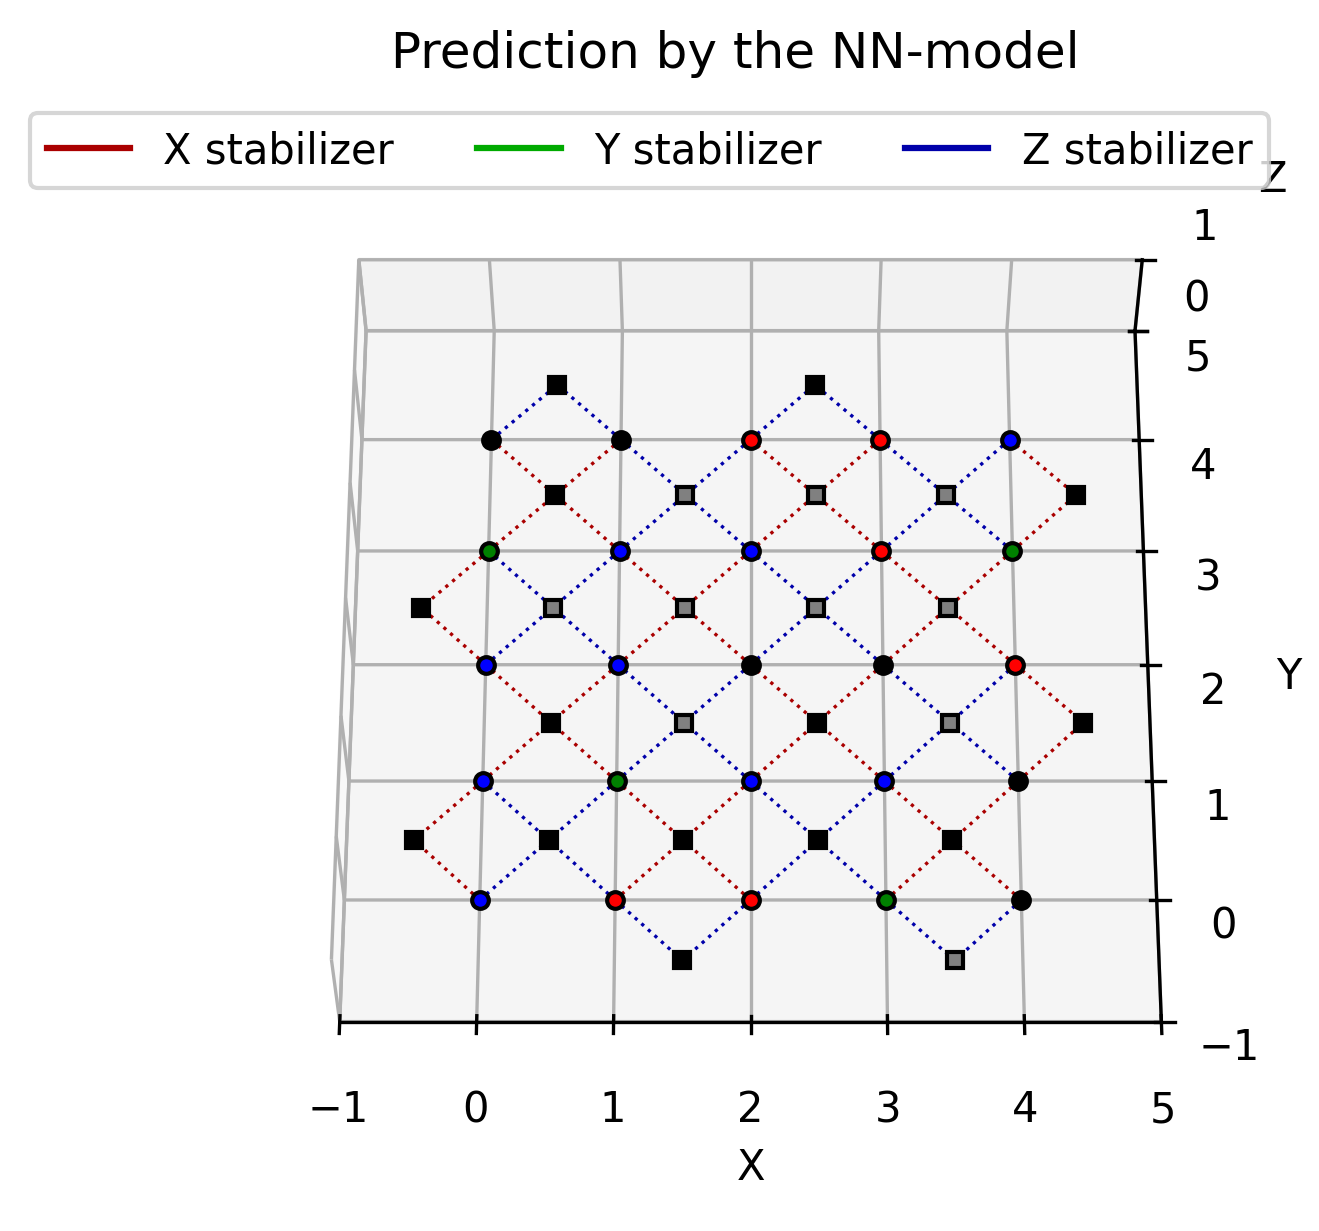

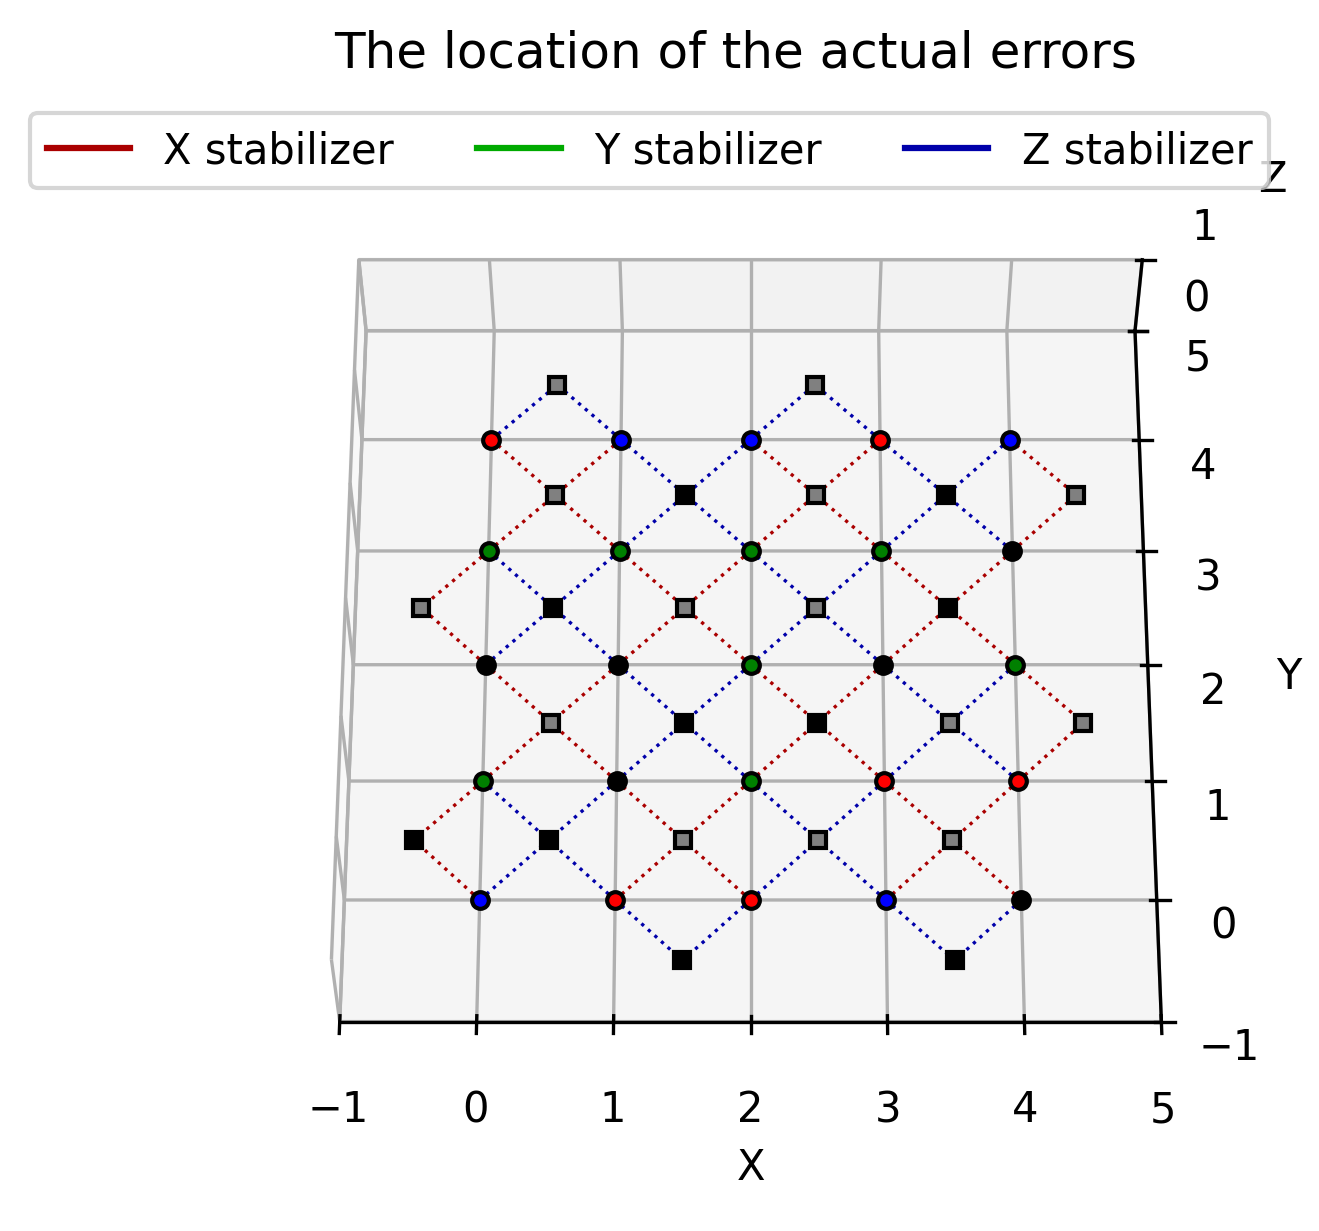

In [10]:
batch_size = 1

subkey, key = jax.random.split(key)
errors = jax_create_error_batch(px, py, pz, size=num_dq, batch_size=batch_size, key=subkey)
syndromes = jax_get_syndromes_batch(Mx, My, Mz, errors)

NN_output = NN_batch(syndromes, params)
NN_correction = batch_interpretate_NN_output(NN_output)
mse_loss_batch_val_grad(syndromes, errors, params)

print("\nPauli correction probability for:\nQubit    I        X        Y        Z\n"+'\n'.join([f'  {i}  '+', '.join([f'{v: 7.1%}' for v in p]) for i, p in enumerate(NN_correction[0].T)]))
print(f'\nLoss = {mse_loss_batch(syndromes, errors, params)}')
print("\nProposed correction by the NN-model:\n",NN_correction.argmax(axis=1))
print("\nThe errors on the device:\n",errors)

_ = qec.show(marker_size=40/d, errors=NN_correction[0].argmax(axis=0), title="Prediction by the NN-model")
_ = qec.show(marker_size=40/d, errors=errors[0], title="The location of the actual errors")